## Ejemplo con el dataset Groceries
#### Master in Data Science - Machine Learning II
#### Santander Meteorology Group. Profesor: Mikel N. Legasa (mikel.legasa@unican.es)

Dado que en la pasada sesión práctica se ha trabajado con el dataset Groceries, es interesante comprobar la consistencia entre los resultados obtenidos por las reglas de asociación, un método como vimos relativamente sencillo de aprender de los datos, y las redes bayesianas.

Para ello, es necesario recuperar los datos de Groceries, contenidos en el paquete arules, y realizar algunas transformaciones para poder trabajar con ellos adecuadamente. Se incluyen todos los pasos en el preproceso de los datos, ya que con frecuencia gran parte del trabajo en minería de datos se corresponderá a tareas de limpieza y preparación de los datos, tediosas a veces, sí, pero necesarias.

In [1]:
library(arules)
library(bnlearn)

Loading required package: Matrix


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write



Attaching package: ‘bnlearn’


The following object is masked from ‘package:arules’:

    discretize




In [2]:
set.seed(1)
data(Groceries)

A continuación, vamos a crear un conjunto de reglas con el algoritmo a priori. Elegimos por ejemplo un soporte de los datos del 0.1%, y una confianza del 30%, y vemos de entro todo el conjunto de reglas generado, qué regla tiene un mayor lift (recordemos que el lift era una medida de dependencia en términos de probabilidad):

In [3]:
rules <- apriori(Groceries,
                 parameter = list(support = 0.001, confidence = 0.3))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5   0.001      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 9 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
sorting and recoding items ... [157 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 done [0.01s].
writing ... [13770 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [4]:
inspect(head(sort(rules, by = "lift")))

    lhs                              rhs                support     confidence
[1] {bottled beer,red/blush wine} => {liquor}           0.001931876 0.3958333 
[2] {ham,white bread}             => {processed cheese} 0.001931876 0.3800000 
[3] {bottled beer,liquor}         => {red/blush wine}   0.001931876 0.4130435 
[4] {Instant food products,soda}  => {hamburger meat}   0.001220132 0.6315789 
[5] {curd,sugar}                  => {flour}            0.001118454 0.3235294 
[6] {sugar,baking powder}         => {flour}            0.001016777 0.3125000 
    coverage    lift     count
[1] 0.004880529 35.71579 19   
[2] 0.005083884 22.92822 19   
[3] 0.004677173 21.49356 19   
[4] 0.001931876 18.99565 12   
[5] 0.003457041 18.60767 11   
[6] 0.003253686 17.97332 10   


La primera regla de asociación, por ejemplo, nos dice que existe una asociación elevada entre la compra de cerveza embotellada y vino, y la compra de licor. Trabajaremos con redes Bayesianas para verificar si esto es cierto.

### Preparación de los datos

Recordemos que la matriz de datos se encuentra dentro del elemento @data. Además, el metadato necesario (en este caso los nombres de los diferentes productos de la compra, están dentro de Groceries@itemInfo$labels). El elemento @data es una matriz *sparse*:

In [5]:
class(Groceries@data)

[1] "ngCMatrix"
attr(,"package")
[1] "Matrix"

Transformamos los datos a una matriz de R:

In [6]:
b <- t(as.matrix(Groceries@data))
product.names <- Groceries@itemInfo$labels
head(b)

FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


El motivo de trabajar con matrices huecas para este tipo de datos, comentado en la pasada sesión de reglas de asociación, es evidente si observamos el tamaño en memoria de la matriz original, y lo comparamos con el de la nueva matriz ordinaria, que es más de 60 veces mayor, conteniendo una gran cantidad de ceros:



In [7]:
print(object.size(Groceries), units = "Mb")
print(object.size(b), units = "Mb")

0.2 Mb
6.3 Mb


A continuación, vamos a evitar algunos caracteres especiales y espacios dentro de los nombre de los productos, ya que en general no es buena idea crear un data.frame con este tipo de caracteres en los nombres de las columnas, ya que pueden dar lugar a diversos errores. Utilizaremos la función gsub para reemplazar estos caracteres problemáticos del siguiente modo:

In [8]:
# Se sustituyen algunos caracteres especiales en las etiquetas que pudieran ser problemáticos, tales como:
# Barras
product.names <- gsub(pattern = "/", replacement = "_or_", x = product.names)
# Espacios en blanco
product.names <- gsub(" ","_", product.names)
# Parentesis
product.names <- gsub("(","", product.names, fixed = TRUE)
product.names <- gsub(")","", product.names, fixed = TRUE)
# Puntos
product.names <- gsub(".","", product.names, fixed = TRUE)
colnames(b) <- product.names

Veamos qué productos contiene el dataset:

In [9]:
head(sort(colSums(b), decreasing = TRUE))

whole_milk             other_vegetables 
                        2513                         1903 
               rolls_or_buns                         soda 
                        1809                         1715 
                      yogurt                bottled_water 
                        1372                         1087 
             root_vegetables               tropical_fruit 
                        1072                         1032 
               shopping_bags                      sausage 
                         969                          924 
                      pastry                 citrus_fruit 
                         875                          814 
                bottled_beer                   newspapers 
                         792                          785 
                 canned_beer                    pip_fruit 
                         764                          744 
    fruit_or_vegetable_juice        whipped_or_sour_cream 
                         711                          705 
                 brown_bread                domestic_eggs 
                         638                          624 
                 frankfurter                    margarine 
                         580                          576 
                      coffee                         pork 
                         571                          567 
                      butter                         curd 
                         545                          524 
                        beef                      napkins 
                         516                          515 
                   chocolate            frozen_vegetables 
                         488                          473 
                     chicken                  white_bread 
                         422                          414 
               cream_cheese_                      waffles 
                         390                          378 
                 salty_snack     long_life_bakery_product 
                         372                          368 
                     dessert                        sugar 
                         365                          333 
                    UHT-milk               hamburger_meat 
                         329                          327 
                     berries             hygiene_articles 
                         327                          324 
                      onions          specialty_chocolate 
                         305                          299 
                       candy                 frozen_meals 
                         294                          279 
              misc_beverages                          oil 
                         279                          276 
                 butter_milk                specialty_bar 
                         275                          269 
                         ham                    beverages 
                         256                          256 
                        meat                    ice_cream 
                         254                          246 
               sliced_cheese                  hard_cheese 
                         241                          241 
                    cat_food                       grapes 
                         229                          220 
                 chewing_gum            red_or_blush_wine 
                         207                          189 
                   detergent                   white_wine 
                         189                          187 
          pickled_vegetables          semi-finished_bread 
                         176                          174 
               baking_powder                       dishes 
                         174                          173 
                       flour                   pot_plants 
                         171                          170 
      

Parece razonable por lo tanto descartar aquellos productos raros, y centrarse en los principales (recordemos que la regla está basada en un support de 0.01). Si tomamos por ejemplo los 100 productos más numerosos, aseguraremos un número mínimo de registros que permitirán construir un modelo bayesiano más robusto, descartando casos raros.

In [10]:
filter.products <- names(sort(colSums(b), decreasing = TRUE)[1:100])
ind <- match(filter.products, product.names)
b <- b[,ind]

Además, nos aseguramos de que la variable es categórica con el método de coerción as.factor. El resultado final, es un data.frame con productos en columnas y transacciones en filas (el mismo formato en que hemos trabajado el conjunto de datos survey):

In [11]:
b <- apply(b, 2, "as.factor")
groc <- as.data.frame(b, stringsAsFactors = T)
head(groc)

,whole_milk,other_vegetables,rolls_or_buns,soda,yogurt,bottled_water,root_vegetables,tropical_fruit,shopping_bags,sausage,⋯,mayonnaise,sweet_spreads,chocolate_marshmallow,candles,specialty_cheese,dog_food,frozen_potato_products,house_keeping_products,turkey,Instant_food_products
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
5,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
6,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


**Ejercicio:** Construye una red Bayesiana (utilizando hill-climbing y el score "Bayesian Information Criterion (BIC)") que modelice los datos y dibuja su grafo.

Resulta ineteresante destacar la dramática reducción en el número de parámetros gracias a la red bayesiana, que resulta mucho más llamativa que en el ejemplo survey:



In [14]:
options(scipen = 999) # esto es simplemente para que no utilice notación científica
nparams(redb)

2^ncol(groc)

[1] 399

[1] 1267650600228229401496703205376

Obviamente, se trata de una red de cierta complejidad, dado el número de nodos (100) y arcos:

In [15]:
paste(length(nodes(grafo)),"nodos y",
      length(arcs(grafo)), "arcos")

[1] "100 nodos y 372 arcos"

**Ejercicio**: Para la siguiente regla:

In [16]:
inspect(head(sort(rules, by = "lift"), 1))

    lhs                              rhs      support     confidence
[1] {bottled beer,red/blush wine} => {liquor} 0.001931876 0.3958333 
    coverage    lift     count
[1] 0.004880529 35.71579 19   


que indica una relacion entre la cerveza y el vino, y la compra de licores. Comprueba de forma analítica,  utilizando inferencia aproximada, que se da está regla

**Ejercicio**: Si sabemos que alguien compra `bottled_beer` pero no `bottled_water` ¿Cambia la probabilidad de que se compre `liquor`?

**Ejercicio**: Para esta misma regla, comprueba mediante la red Bayesiana el *lift*, *support* y *confidence*:

 $$\frac{\frac{ \text{Transacciones que contienen } X, Y}{\text{Transacciones que contienen } X}}{\frac{ \text{Transacciones que contienen }  Y}{\text{Todas las Transacciones}}}$$

El soporte corresponde a

 $$\frac{\text{Transacciones que contienen } X, Y}{\text{Todas las Transacciones}}$$

Y la *confidence* a

$$ \frac{ \text{Transacciones que contienen } X, Y}{\text{Transacciones que contienen } X}$$

**Ejercicio**: ¿Existe alguna v-estructura que involucre `bottled_beer`?

**Ejercicio**: ¿Comprar o no comprar leche (`whole_milk`) tiene influencia sobre comprar Licor `liquor`? ¿Y agua (`bottled_water`)?

Dado que estamos realizando inferencia aproximada, los resultados no son exactos, y por lo tanto se mueven dentro de un margen de error muestral. Veamos los resultados tras 100 realizaciones:

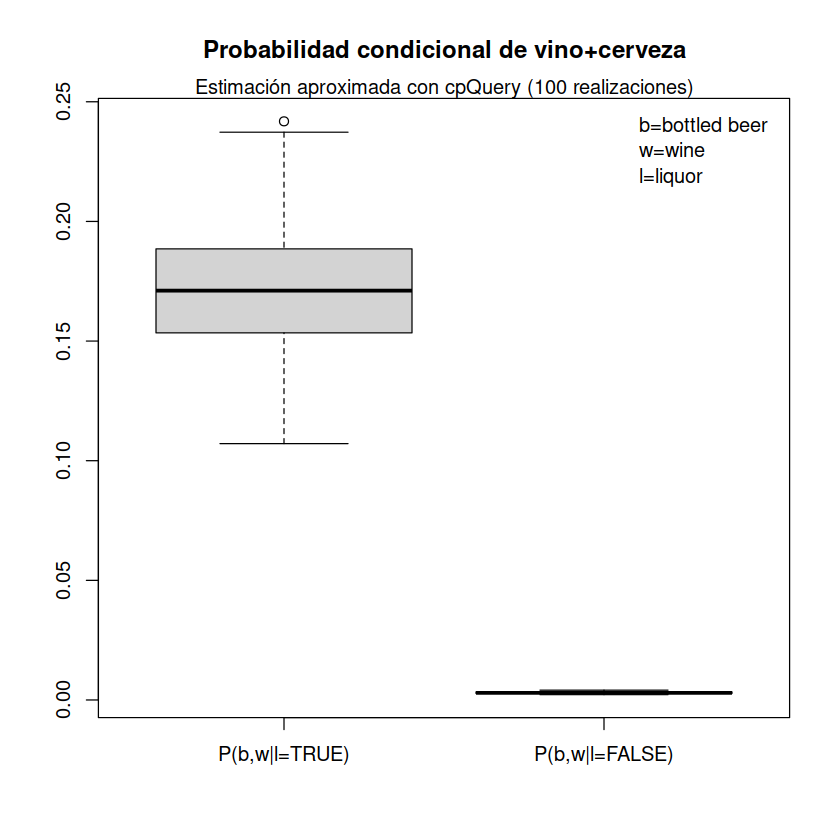

In [23]:
liq.no <- liq.yes <- rep(NA,100)
for (i in 1:100) {
    liq.no[i] <- cpquery(redb,
                         event = (bottled_beer == TRUE) & (red_or_blush_wine == TRUE),
                         evidence = (liquor == FALSE))
    liq.yes[i] <- cpquery(redb,
                          event = (bottled_beer == TRUE) & (red_or_blush_wine == TRUE),
                          evidence = (liquor == TRUE))
}
df <- cbind.data.frame("P(b,w|l=TRUE)" = liq.yes,
                       "P(b,w|l=FALSE)" = liq.no)
boxplot(df, main = "Probabilidad condicional de vino+cerveza")
mtext("Estimación aproximada con cpQuery (100 realizaciones)")
legend("topright", c("b=bottled beer","w=wine","l=liquor"), bty = "n")

### Referencias

Gutiérrez, J.M., Cano, R., Cofiño, A.S., Sordo, C., 2004. Redes probabilísticas y neuronales en las ciencias atmosféricas. Centro de Publicaciones, Ministerio de Medio Ambiente, Madrid, Spain.

Scutari, M., Denis, J.-B., 2014. Bayesian networks: with examples in R.

Scutari, M., 2014. Bayesian Network Constraint-Based Structure Learning Algorithms: Parallel and Optimised Implementations in the bnlearn R Package. http://arxiv.org/abs/1406.7648

r-bayesian-networks. http://www.r-bayesian-networks.org/ (Last accessed 18 Nov 2017)

Nagarajan, R., Scutari, M. and Lèbre, S. 2013. Bayesian networks in R: with applications in systems biology, Use R! Springer, New York.

